# Python Notebok on Reproducing Code

This Python notebook will illustrate the steps taken to produce the two sets of vecotr fields in the study using a subset of the Milan Telecommunications data. The aim of this notebook is that it can be used to replicate the study on different case studies. 

#### Import Libraries and Files

In [38]:
#Import libraries needed to run code
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [39]:
# Read in files
milan_grid = gpd.read_file("milan_grid.geojson")
# Read in the subset of telecommunications data - first 100,000 rows of the data
milan_data = pd.read_csv("milan_subset.csv")

In [40]:
# Preview the data
milan_grid.head()

,cellId,Long,Lat,geometry
0,1,9.01299,45.35774,"POLYGON ((9.01149 45.35880, 9.01449 45.35880, ..."
1,2,9.01599,45.35774,"POLYGON ((9.01449 45.35880, 9.01749 45.35880, ..."
2,3,9.01899,45.35774,"POLYGON ((9.01749 45.35880, 9.02049 45.35880, ..."
3,4,9.02199,45.35774,"POLYGON ((9.02049 45.35880, 9.02349 45.35880, ..."
4,5,9.02499,45.35774,"POLYGON ((9.02349 45.35880, 9.02649 45.35880, ..."


In [41]:
# Preview the data
milan_data.head()

,Unnamed: 0,time,origin,destination,flow_strength
0,0,1383297600000,1,1,0.000145
1,1,1383300000000,1,1,0.000289
2,2,1383306000000,1,1,0.000217
3,3,1383306600000,1,1,0.000069
4,4,1383308400000,1,1,0.000072


#### Clean the Data

In [42]:
# Get rid of rows where origin and destination are the same 
milan_to_milan = milan_data[milan_data.origin != milan_data.destination]

In [43]:
# Sort Values based on flow strength and drop duplicates so that only the strongest valuefor each origin remains
milan_to_milan = milan_to_milan.sort_values('flow_strength', ascending=False).drop_duplicates(['origin'])

In [44]:
# Merge telecommunications data with geometries to get lat/long of origin
milan_to_milan = pd.merge(milan_to_milan, milan_grid, left_on='origin', right_on='cellId', how='left')

In [45]:
# Merge telecommunications data with geometries to get lat/long of destination
milan_to_milan = pd.merge(milan_to_milan, milan_grid, left_on='destination', right_on='cellId', how='left')

In [46]:
milan_to_milan.head()

,Unnamed: 0,time,origin,destination,flow_strength,cellId_x,Long_x,Lat_x,geometry_x,cellId_y,Long_y,Lat_y,geometry_y
0,6432,1383322200000,10000,7885,0.023963,10000,9.31118,45.56673,"POLYGON ((9.30968 45.56779, 9.31269 45.56779, ...",7885,9.26580,45.52243,"POLYGON ((9.26430 45.52349, 9.26730 45.52348, ..."
1,96359,1383312000000,1024,5955,0.017982,1024,9.08203,45.37887,"POLYGON ((9.08053 45.37993, 9.08353 45.37992, ...",5955,9.17540,45.48241,"POLYGON ((9.17390 45.48347, 9.17690 45.48347, ..."
2,5771,1383322800000,1000,3962,0.013581,1000,9.31013,45.37636,"POLYGON ((9.30864 45.37742, 9.31164 45.37741, ...",3962,9.19630,45.44007,"POLYGON ((9.19480 45.44113, 9.19781 45.44113, ..."
3,4432,1383300000000,100,5267,0.008299,100,9.31003,45.35732,"POLYGON ((9.30853 45.35839, 9.31153 45.35838, ...",5267,9.21143,45.46754,"POLYGON ((9.20993 45.46860, 9.21293 45.46860, ..."
4,76772,1383315000000,1019,4649,0.006573,1019,9.06702,45.37888,"POLYGON ((9.06552 45.37994, 9.06852 45.37993, ...",4649,9.15728,45.45494,"POLYGON ((9.15578 45.45600, 9.15878 45.45600, ..."


In [47]:
# Clean data to keep only desired columns
milan_to_milan = milan_to_milan[['origin', 'destination', 'flow_strength', 'Lat_x', 'Long_x', 'Lat_y', 'Long_y']]

In [48]:
# Create two new columns - difference in lat/long betwen origin and destination
milan_to_milan['diff_lat'] = milan_to_milan['Lat_y'] - milan_to_milan['Lat_x']
milan_to_milan['diff_long'] = milan_to_milan['Long_y'] - milan_to_milan['Long_x']

In [49]:
# Preview the data
milan_to_milan.head()

,origin,destination,flow_strength,Lat_x,Long_x,Lat_y,Long_y,diff_lat,diff_long
0,10000,7885,0.023963,45.56673,9.31118,45.52243,9.26580,-0.04430,-0.04538
1,1024,5955,0.017982,45.37887,9.08203,45.48241,9.17540,0.10354,0.09337
2,1000,3962,0.013581,45.37636,9.31013,45.44007,9.19630,0.06371,-0.11383
3,100,5267,0.008299,45.35732,9.31003,45.46754,9.21143,0.11022,-0.09860
4,1019,4649,0.006573,45.37888,9.06702,45.45494,9.15728,0.07606,0.09026


## Plot vectors proportional to distance between origin and destination

Quiver plot requires:
- *X, Y* which define the arrow locations - *origin, destination*
- *U, V* which define the arrow directions - *difference in longitude, and latitude*

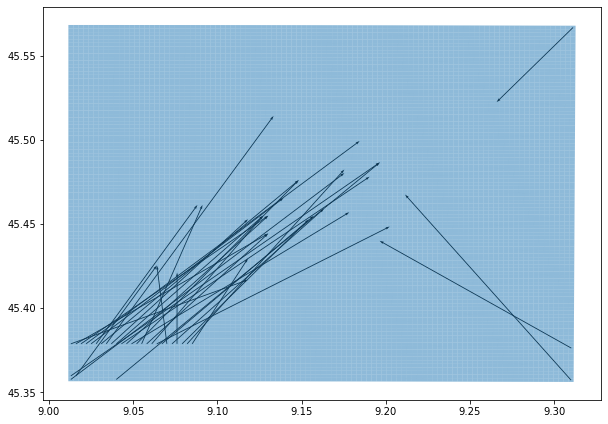

In [50]:
# Define X, Y, U, and V
X = milan_to_milan['Long_x'] 
Y= milan_to_milan['Lat_x']
U = milan_to_milan['diff_long']
V = milan_to_milan['diff_lat']

# Set up the figure and axes
f, ax = plt.subplots(1, figsize=(10, 10))

# Plot the 2D arrows (Vectors)
# For the arrow to connect origin and destination, set scale to 1
# A higher scale reduces arrow length 
ax.quiver(X, Y, U, V, units='xy',scale=1, width=0.0005)

# plot the Milan grid
milan_grid.plot(ax=ax, alpha=0.5)

# Set the aspect to equal
ax.set_aspect('equal')

# Show figure
plt.show()

---
## Vectors proportional to the volume of flow

To make the vectors proportional to the volume of flow, it is first necessary to normalize the vectors. Normalizing the vectors makes all vectors' length equal but retains the direction.   

In [51]:
# preview the data
milan_to_milan.head()

,origin,destination,flow_strength,Lat_x,Long_x,Lat_y,Long_y,diff_lat,diff_long
0,10000,7885,0.023963,45.56673,9.31118,45.52243,9.26580,-0.04430,-0.04538
1,1024,5955,0.017982,45.37887,9.08203,45.48241,9.17540,0.10354,0.09337
2,1000,3962,0.013581,45.37636,9.31013,45.44007,9.19630,0.06371,-0.11383
3,100,5267,0.008299,45.35732,9.31003,45.46754,9.21143,0.11022,-0.09860
4,1019,4649,0.006573,45.37888,9.06702,45.45494,9.15728,0.07606,0.09026


In [52]:
# Normalize the vectors so that all lengths are equal and direction is retained
milan_to_milan['norm_diff_lat'] = milan_to_milan['diff_lat'] / np.sqrt(milan_to_milan['diff_lat']**2 + milan_to_milan['diff_long']**2)
milan_to_milan['norm_diff_long'] = milan_to_milan['diff_long'] / np.sqrt(milan_to_milan['diff_long']**2 + milan_to_milan['diff_lat']**2)

Normalizing the vectors results in all arrow lengths equal to 1. In this study, it is important to remember that we are working in degrees. Plotting these arrows where the lengths are equal to 1 degree would result in very long arrows as 1 degree is roughly equivalent to 111km. As the volumes of flow are very small, weighting the arrow lengths will reduce the length of the arrows. In other studies, further pre-processing may be needed to reduce the arrow length - this can be achieved by modifying the `scale` paramater in quiver plot.

In [53]:
# Vectors weighted on the volume of flow
milan_to_milan['weight_diff_lat'] = milan_to_milan['norm_diff_lat']*milan_to_milan['flow_strength']
milan_to_milan['weight_diff_long'] = milan_to_milan['norm_diff_long']*milan_to_milan['flow_strength']

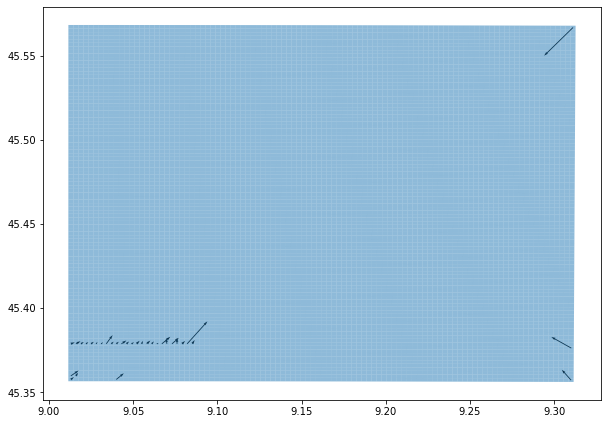

In [54]:
# plot the vectors weighted on the volume of flow

# Define X, Y, U, and V
X = milan_to_milan['Long_x'] 
Y= milan_to_milan['Lat_x']
U = milan_to_milan['weight_diff_long']
V = milan_to_milan['weight_diff_lat']

# Set up the figure and axes
f, ax = plt.subplots(1, figsize=(10, 10))

# Plot the 2D arrows (Vectors)
# A higher scale reduces arrow length 
ax.quiver(X, Y, U, V, units='xy',scale=1, width=0.0005)

# plot the Milan grid
milan_grid.plot(ax=ax, alpha=0.5)

# Set the aspect to equal
ax.set_aspect('equal')

# Show figure
plt.show()

From the plot above, it appears that the strongest volume of flow in this subset is from the cell in the top-right - *cellId 10,000*. Let's explore the data to see if this is the case. 

In [55]:
# Select the row in the subset with the strongest flow volume
milan_to_milan.loc[milan_to_milan['flow_strength'] == milan_to_milan['flow_strength'].max()]

,origin,destination,flow_strength,Lat_x,Long_x,Lat_y,Long_y,diff_lat,diff_long,norm_diff_lat,norm_diff_long,weight_diff_lat,weight_diff_long
0,10000,7885,0.023963,45.56673,9.31118,45.52243,9.2658,-0.0443,-0.04538,-0.698541,-0.71557,-0.016739,-0.017147


Origin ID of the strongest flow volume in the subset = 10,000

---
This notebook can be used to replicate the study on a different stdy area. The only requirements are that there is Orgin-Destination data with coordinates. The effectiveness of the visualisation is highly dependent on the customisation of the vectors, including transparency, scale, linewidth, etc. Also, to improve the effectiveness of the visualisation, it is possible to add a basemap using `contextily`.   